# Train a language model from scratch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [ ]:
#torch.cuda.empty_cache() 

Prior to going on with this notebook, please run the batch script `lm_1_prepare_wiki.bat`, to download and extract Wikipedia content in the desired language.

## Preparing the data

In [3]:
lang = "it"

In [4]:
DATA_PATH = Path('../lm/data/wiki/' + lang)
DATA_PATH.mkdir(exist_ok=True)

In [5]:
MODEL_PATH= DATA_PATH/'models/'
MODEL_PATH.mkdir(exist_ok=True)

Let's use a smaller dataset to understand the concepts. If you wish to run on the full dataset, define debug as empty string.

In [6]:
debug = "_debug"

In [28]:
debug = ""

### 1. Text Pre-Processing

SpaCy (https://spacy.io/) does support the following languages: 'en', 'de', 'es', 'pt', 'fr', 'it', 'nl'.  
**If you want to train a LM in an unsupported language, you need to provide and implement a proper tokenizer.**

A possible alternative to use is **SentencePiece** by Google (https://github.com/google/sentencepiece)

In [7]:
try:
    spacy.load(lang)
except OSError:
    print(f'spacy tokenization model is not installed for "{lang}".')
    lang = lang if lang in ['en', 'de', 'es', 'pt', 'fr', 'it', 'nl'] else 'xx'
    print(f'In an Administrator Command Prompt, type: python -m spacy download {lang}')

spacy tokenization model is not installed for "it".
In an Administrator Command Prompt, type: python -m spacy download it


Change the following settings accordingly, to train a model with the specified vocabulary settings and language

In [8]:
max_vocab = 60000
min_freq = 2
chunksize = 24000

In [9]:
tokenizer = Tokenizer(lang=lang, n_cpus=8) # change CPUs according to your configuration

In [10]:
df_trn = pd.read_csv(DATA_PATH/f'train{debug}.csv', header=None)

In [11]:
df_val = pd.read_csv(DATA_PATH/f'val{debug}.csv', header=None)

In [12]:
doc(TextLMDataBunch)

In [13]:
%%time
data = TextLMDataBunch.from_df(DATA_PATH, df_trn, df_val, tokenizer=tokenizer,
                               text_cols=0, chunksize=chunksize, max_vocab=max_vocab, min_freq=min_freq)

Wall time: 48.8 s


In [14]:
data.save(f'tmp{debug}')

In [15]:
x,y = next(iter(data.train_dl))
example = x[:10,:20].cpu()
texts = pd.DataFrame([data.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,xxunk,si,ottengono,due,nuove,molecole,che,sono,l'una,xxunk,speculare,dell'altra,",",la,molecola,è,prochirale,.,xxmaj,gli
1,cavalli,o,xxunk,.,xxmaj,in,xxmaj,italia,generalmente,era,vista,come,un'arma,ibrida,",",che,xxunk,in,sé,le
2,il,turno,passa,poi,al,giocatore,alla,sua,destra,che,a,sua,volta,prenderà,una,carta,e,così,via,.
3,",",tutti,possono,usare,questa,tipologia,di,disegni,",",senza,offendere,la,cultura,.,xxmaj,avevano,",",inoltre,",",la
4,bruno,e,una,parte,di,xxmaj,wasseralfingen,è,sul,xxmaj,giura,nero,.,\r\n\r\n,xxmaj,estensione,del,territorio,della,città
5,",",guidati,da,xxmaj,tito,xxmaj,tazio,",",attaccarono,i,xxmaj,romani,",",per,vendicarsi,del,xxmaj,ratto,delle,sabine
6,xxmaj,l'edificio,.,\r\n,xxmaj,la,barchessa,è,parte,di,un,vasto,complesso,comprendente,anche,una,villa,veneta,distrutta,verso
7,maggior,parte,del,film,è,ambientato,di,notte,.,xxmaj,l'unico,momento,in,cui,vediamo,xxmaj,marte,durante,il,giorno
8,monumentale,in,basalto,finemente,lavorata,",",xxunk,nella,facciata,anteriore,e,in,quella,posteriore,due,scalinate,simboliche,.,i,fianchi
9,xxmaj,si,è,registrato,inoltre,",",in,rassegne,dedicate,al,teatro,settecentesco,",",un,recente,interesse,per,le,commedie,","


### 2. Pre-train the language model

In [16]:
bs = 32

In [30]:
data = TextLMDataBunch.load(DATA_PATH, f"tmp{debug}", bs=bs)

In [31]:
learn = language_model_learner(data, bptt = 70, emb_sz = 400, nh = 1150, nl = 3,
                               drop_mult = 0.05, alpha = 2, beta = 1, clip = 0.15, wd = 1e-3)

In [32]:
learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

Let's find an optimal learning rate:

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


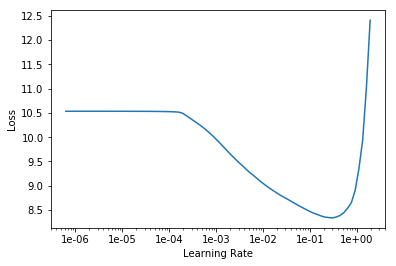

In [21]:
learn.recorder.plot(skip_end=5)

Let's train our model:

In [22]:
epochs = 1

In [23]:
max_lr = 1e-3

In [24]:
lr = slice(max_lr/(2.6**4), max_lr)

In [25]:
learn.fit_one_cycle(cyc_len = epochs, 
                    max_lr = lr,       # learning rate
                    div_factor = 20,   # factor to discount from max
                    moms = (0.8, 0.7), # momentums
                    pct_start = 0.1    # where the peak is at 
                    )

epoch,train_loss,valid_loss,accuracy
1,6.251325,6.123973,0.157997


We can now save it for use in transfer-learning scenario for other tasks, such as document classification, sentiment analysis, or anything else related to NLP. In particular, we want to save all the Neural Network **excluding** the last layer, used as dummy classification task (next word prediction) for building the proper language model.

In [26]:
learn.save_encoder('enc_lstm')
learn.save('model_lstm')

### 3. Verify the quality of the model

Let's try to see what it predicts after a few given words.

In [33]:
learn.load("model_lstm")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (205681 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\lm\data\wiki\it
x: LMTextList (205681 items)
[Text 
 xxbos xxfld 1 xxmaj _unk_ 

 xxmaj _unk_ o _unk_ ( in francese , " _unk_ " ) è un tipo di organo costituito da una ( o più ) tastiera , " manuale " , e da due pedali per azionare i _unk_ per l'aria ; infatti _unk_ è uno strumento a serbatoio d'aria . xxmaj _unk_ , inoltre , rientra nella categoria degli strumenti _unk_ ad ancia libera , poiché il suono che esso produce è dovuto a delle ance . 

 xxmaj _unk_ occidentale . 
 xxmaj col termine italiano _unk_ si comprendono due differenti tipi di strumento : quello ad aria compressa , che è _unk_ " di tipo francese , e quello ad aria aspirata , che è il " reed _unk_ " americano ( ma anche inglese e tedesco ) . xxmaj nel primo caso , i _unk_ _unk_ _unk_ , attraverso una “ camera del vento ” o “ serbatoio ” ( " _unk_ " , in francese ) , 

In [34]:
TEXT = "Questa è una prova"
N_WORDS = 15
N_SENTENCES = 2

In [35]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

Questa è una prova della sua capacità di saletta , non solo per la sua reputazione di scrittore ,
Questa è una prova del motivo per cui i xxmaj duchesne , alle quali si era consumato la maggior


Perplexity:

In [36]:
np.exp(3.596128)

36.45680007355578